# 🧪 Stroke Report NLP Exploration

This notebook explores the Classical NLP pipeline for extracting keywords from German stroke radiology reports.

## Setup and Imports

In [1]:
import os
import sys
sys.path.append('..')  # Add parent directory to import our modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Custom modules
from extractor.preprocessing import TextPreprocessor
from extractor.keyword_rules import KeywordExtractor
from extractor.spacy_ner_wrapper import SpacyNERExtractor

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Initialize NLP Components

In [2]:
# Initialize our NLP pipeline components
preprocessor = TextPreprocessor()
keyword_extractor = KeywordExtractor()
ner_extractor = SpacyNERExtractor()

print("✅ NLP components initialized successfully!")

✅ NLP components initialized successfully!


## 2. Sample Data Creation and Analysis

In [3]:
# Create extended sample reports for analysis
sample_reports = [
    {
        'id': 'report_001',
        'text': """
        Patient wurde in Allgemeinanästhesie behandelt. Beginn der Intervention um 08:32 Uhr.
        Verwendung des Trevo Stentretriever Systems. rtPA wurde um 07:45 verabreicht.
        Mechanische Thrombektomie mit SOFIA Katheter durchgeführt.
        Finales Ergebnis: TICI 3. Keine Komplikationen aufgetreten.
        """
    },
    {
        'id': 'report_002', 
        'text': """
        Sedierung für die Prozedur. Start: 09:15 Uhr mit Aspiration using Penumbra System.
        Catch Mini device eingesetzt. Urokinase als Thrombolytikum verwendet.
        Leichte Blutung nach der Intervention beobachtet. TICI 2b erreicht.
        """
    },
    {
        'id': 'report_003',
        'text': """
        Lokale Anästhesie für den Eingriff. Beginn: 10:20. 
        Solitaire Stentretriever verwendet für die mechanische Rekanalisation.
        Heparin antikoagulation. Embotrap als backup device.
        Perforation der Gefäßwand aufgetreten. TICI 1 Ergebnis.
        """
    },
    {
        'id': 'report_004',
        'text': """
        Vollnarkose eingeleitet um 11:45 Uhr. Tenecteplase i.v. verabreicht.
        Mechanische Thrombektomie mit Trevo Stentretriever und SOFIA Aspiration.
        Zusätzlich Aspirin und Heparin gegeben. TICI 2a erreicht.
        Postinterventionelles Hämatom festgestellt.
        """
    },
    {
        'id': 'report_005',
        'text': """
        Patient unter Sedierung. Interventionsbeginn: 14:30.
        Primäre Aspiration mit Penumbra System erfolgreich.
        Keine Medikation erforderlich. Komplikationsloser Verlauf.
        Finales TICI 3 Ergebnis nach mechanischer Embolektomie.
        """
    }
]

print(f"Created {len(sample_reports)} sample reports for analysis.")

Created 5 sample reports for analysis.


## 3. Text Preprocessing Analysis

In [4]:
# Analyze preprocessing effects
print("=== PREPROCESSING ANALYSIS ===")
print()

for i, report in enumerate(sample_reports[:2]):  # Show first 2 reports
    original = report['text']
    cleaned = preprocessor.clean_text(original)
    
    print(f"📄 Report {report['id']}:")
    print(f"Original length: {len(original)} chars")
    print(f"Cleaned length: {len(cleaned)} chars")
    print(f"Original: {original[:100]}...")
    print(f"Cleaned: {cleaned[:100]}...")
    print("-" * 50)
    print()

=== PREPROCESSING ANALYSIS ===

📄 Report report_001:
Original length: 324 chars
Cleaned length: 282 chars
Original: 
        Patient wurde in Allgemeinanästhesie behandelt. Beginn der Intervention um 08:32 Uhr.
     ...
Cleaned: patient wurde in allgemeinanästhesie behandelt. beginn der intervention um 08:32 uhr. verwendung des...
--------------------------------------------------

📄 Report report_002:
Original length: 254 chars
Cleaned length: 220 chars
Original: 
        Sedierung für die Prozedur. Start: 09:15 Uhr mit Aspiration using Penumbra System.
        ...
Cleaned: sedierung für die prozedur. start: 09:15 uhr mit aspiration using penumbra system. catch mini device...
--------------------------------------------------



## 4. Keyword Extraction Pattern Analysis

In [5]:
# Test keyword extraction on all samples
extraction_results = []

for report in sample_reports:
    cleaned_text = preprocessor.clean_text(report['text'])
    results      = keyword_extractor.extract_all(cleaned_text, report['id'])
    extraction_results.append(results)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(extraction_results)

print("=== KEYWORD EXTRACTION RESULTS ===")
print(results_df.to_string())
print()

# Show extraction statistics
print("=== EXTRACTION STATISTICS ===")
# Update categories to match actual DataFrame columns
categories = [
    'anaesthesia',  # anaesthesia extraction
    'periprocedural_ia_thrombolysis',  # medication: thrombolysis
    'treatment_method',  # if exists, otherwise skip or map to actual column
    'device',  # if exists, otherwise skip or map to actual column
    'tici_score',
    'complications'
]

for category in categories:
    if category in results_df.columns:
        non_null_count = results_df[category].notna().sum()
        coverage = (non_null_count / len(results_df)) * 100
        print(f"{category.replace('_', ' ').title()}: {non_null_count}/{len(results_df)} reports ({coverage:.1f}%)")
    else:
        print(f"{category.replace('_', ' ').title()}: Column not found in results_df")
   

=== KEYWORD EXTRACTION RESULTS ===
    report_id  text_length          anaesthesia aspiration_catheter_used guide_catheter_used microcatheter_used                   stent_retriever_used tici_score periprocedural_ia_thrombolysis periprocedural_antiplatelet   complications site_of_occlusion stenoses_cervical_arteries extracranial_pta_stenting intracranial_pta_stenting technique_first_maneuver visualisation_vessels number_recanalization_attempts periprocedural_spasmolytic start_time_intervention end_time_intervention
0  report_001          282  allgemeinanästhesie                    sofia                None               None                [stentretriever, trevo]     tici 3                           rtpa                        None  komplikationen              None                       None                      None                      None                     None                  None                           None                       None                   08:32                  

## 5. Pattern Matching Deep Dive

In [6]:
# Analyze individual pattern performance
print("=== PATTERN MATCHING ANALYSIS ===")
print()

# Test each category's patterns
test_text = " ".join([report['text'] for report in sample_reports])
cleaned_test_text = preprocessor.clean_text(test_text)

for category, patterns in keyword_extractor.patterns.items():
    print(f"🔍 {category.upper()}:")
    total_matches = 0
    
    for pattern in patterns:
        matches = re.findall(pattern, cleaned_test_text, re.IGNORECASE)
        if matches:
            print(f"  Pattern '{pattern}' → {matches}")
            total_matches += len(matches)
        else:
            print(f"  Pattern '{pattern}' → No matches")
    
    print(f"  Total matches: {total_matches}")
    print()

# Test time patterns separately
print("⏰ TIME PATTERNS:")
time_patterns = [
    r'\b\d{1,2}:\d{2}\b',           # Matches times like 08:32, 14:30
    r'\b\d{1,2}\.\d{2}\b',          # Matches times like 10.20 (alternative format)
    r'\bum\b \d{1,2}:\d{2}\b',      # Matches 'um 08:32'
    r'\bbeginn\b.*?\d{1,2}:\d{2}\b' # Matches 'Beginn ... 08:32'
]
for pattern in time_patterns:
    matches = re.findall(pattern, cleaned_test_text, re.IGNORECASE)
    if matches:
        print(f"  Pattern '{pattern}' → {matches}")
    else:
        print(f"  Pattern '{pattern}' → No matches")

=== PATTERN MATCHING ANALYSIS ===

🔍 ANAESTHESIA:
  Pattern '\bintubationsnarkose\b' → No matches
  Pattern '\ballgemeinanästhesie\b' → ['allgemeinanästhesie']
  Pattern '\bsedierung\b' → ['sedierung', 'sedierung']
  Pattern '\blokalanästhesie\b' → No matches
  Pattern '\bnarkose\b' → No matches
  Pattern '\bvollnarkose\b' → ['vollnarkose']
  Total matches: 4

🔍 ASPIRATION_CATHETER_USED:
  Pattern '\baspirationskatheter\b' → No matches
  Pattern '\bsofia\b' → ['sofia', 'sofia']
  Pattern '\bpenumbra\b' → ['penumbra', 'penumbra']
  Pattern '\bcatch\s+mini\b' → ['catch mini']
  Total matches: 5

🔍 GUIDE_CATHETER_USED:
  Pattern '\bguide.?katheter\b' → No matches
  Pattern '\bführungskatheter\b' → No matches
  Total matches: 0

🔍 MICROCATHETER_USED:
  Pattern '\bmikrokatheter\b' → No matches
  Pattern '\bmicrocatheter\b' → No matches
  Total matches: 0

🔍 STENT_RETRIEVER_USED:
  Pattern '\bstent.?retriever\b' → ['stentretriever', 'stentretriever', 'stentretriever']
  Pattern '\btrevo\b' →

## 6. spaCy NER Analysis

In [7]:
# Analyze spaCy NER performance
print("=== spaCy NER ANALYSIS ===")
print()

all_entities = []
all_noun_phrases = []

for report in sample_reports:
    cleaned_text = preprocessor.clean_text(report['text'])
    
    # Extract entities
    entities = ner_extractor.extract_entities(cleaned_text)
    noun_phrases = ner_extractor.extract_noun_phrases(cleaned_text)
    
    all_entities.extend(entities)
    all_noun_phrases.extend(noun_phrases)
    
    print(f"📄 {report['id']}:")
    print(f"  Entities: {[ent['text'] for ent in entities]}")
    print(f"  Noun phrases: {noun_phrases[:5]}...")  # Show first 5
    print()

# Entity statistics
if all_entities:
    entity_labels = [ent['label'] for ent in all_entities]
    entity_counts = Counter(entity_labels)
    
    print("Entity Label Distribution:")
    for label, count in entity_counts.most_common():
        print(f"  {label}: {count}")
else:
    print("No entities found by spaCy NER")

=== spaCy NER ANALYSIS ===

📄 report_001:
  Entities: ['trevo stentretriever systems', 'rtpa', 'sofia katheter', 'finales', 'tici 3.']
  Noun phrases: ['patient', 'allgemeinanästhesie', 'beginn', 'der intervention', 'verwendung']...

📄 report_002:
  Entities: ['prozedur', 'start', 'aspiration using penumbra system', 'catch mini device', 'urokinase', 'tici 2b']
  Noun phrases: ['sedierung', 'die prozedur', 'start', 'aspiration', 'penumbra system']...

📄 report_003:
  Entities: ['heparin antikoagulation', 'embotrap', 'tici']
  Noun phrases: ['lokale anästhesie', 'den eingriff', 'beginn: 10:20.', 'solitaire', 'die mechanische rekanalisation']...

📄 report_004:
  Entities: ['vollnarkose', 'tenecteplase i.v.', 'trevo stentretriever', 'sofia aspiration', 'tici']
  Noun phrases: ['vollnarkose', 'tenecteplase i.v', 'mechanische thrombektomie', 'sofia', 'aspiration']...

📄 report_005:
  Entities: ['14:30.', 'penumbra system', 'komplikationsloser', 'finales tici']
  Noun phrases: ['patient', 'se

## 7. Visualization and Analysis"

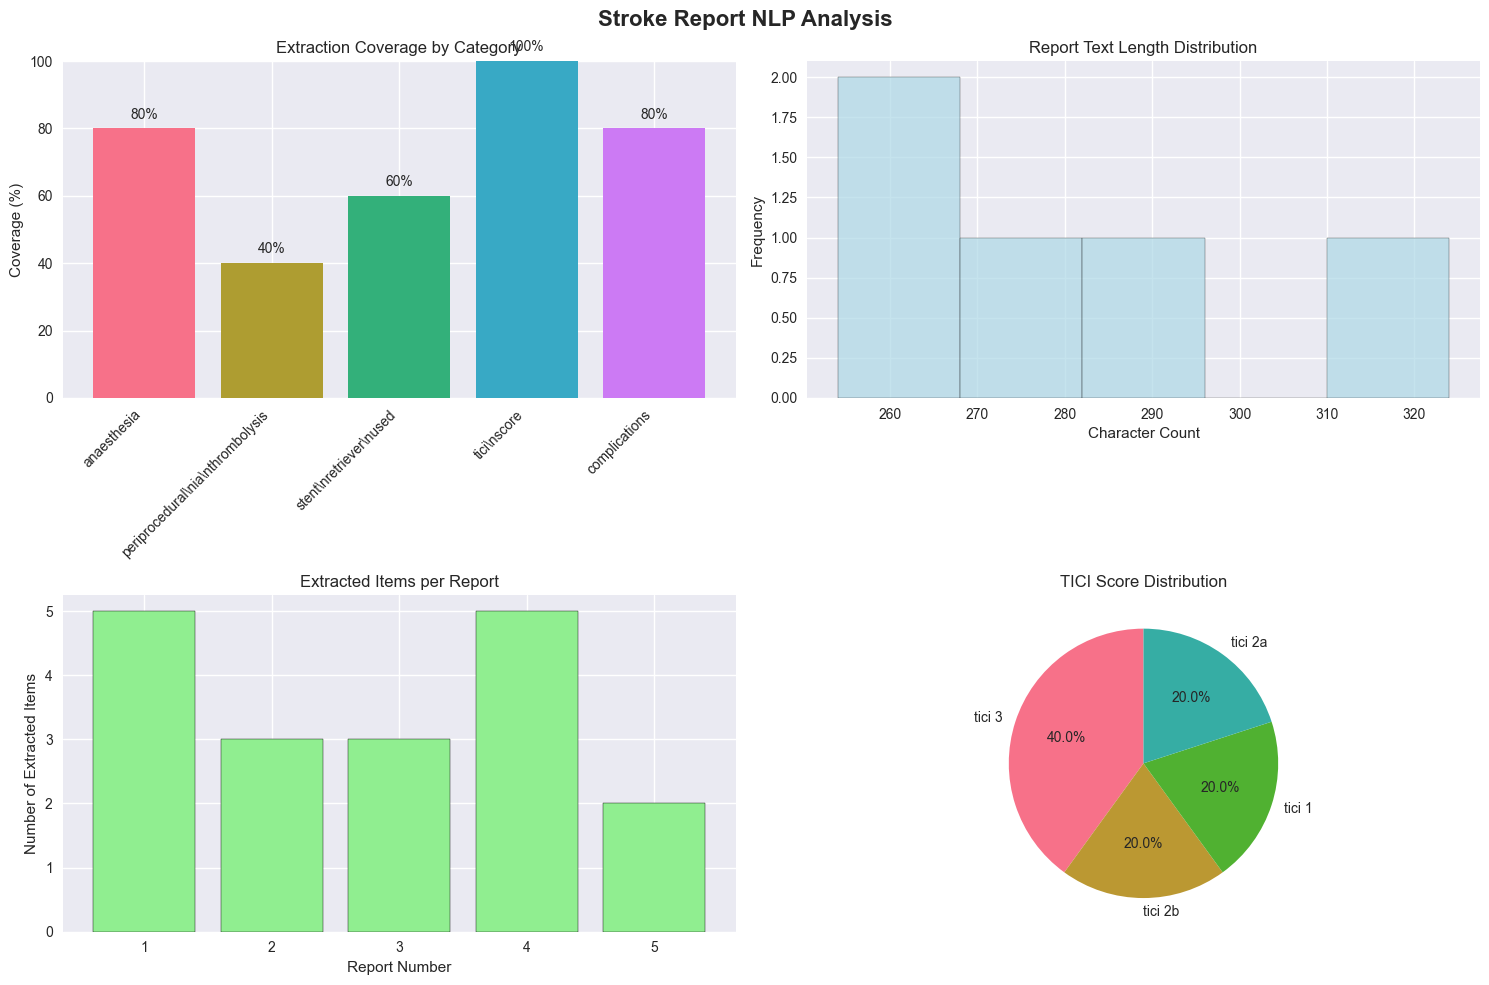

In [11]:

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stroke Report NLP Analysis', fontsize=16, fontweight='bold')

# 1. Extraction coverage by category
ax1 = axes[0, 0]
# Only include columns that exist in results_df
categories = [cat for cat in ['anaesthesia', 'periprocedural_ia_thrombolysis', 'treatment_method', 'stent_retriever_used', 'tici_score', 'complications'] if cat in results_df.columns]
coverages = [(results_df[cat].notna().sum() / len(results_df)) * 100 for cat in categories]

bars = ax1.bar(range(len(categories)), coverages, color=sns.color_palette("husl", len(categories)))
ax1.set_title('Extraction Coverage by Category')
ax1.set_ylabel('Coverage (%)')
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels([cat.replace('_', '\\n') for cat in categories], rotation=45, ha='right')
ax1.set_ylim(0, 100)

# Add value labels on bars
for bar, coverage in zip(bars, coverages):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{coverage:.0f}%', ha='center', va='bottom')

# 2. Text length distribution
ax2 = axes[0, 1]
text_lengths = [len(report['text']) for report in sample_reports]
ax2.hist(text_lengths, bins=5, color='lightblue', edgecolor='black', alpha=0.7)
ax2.set_title('Report Text Length Distribution')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Frequency')

# 3. Extracted items count
ax3 = axes[1, 0]
items_per_report = []
for _, row in results_df.iterrows():
    count = 0
    for cat in categories:
        val = row[cat]
        # If value is a list or np.ndarray, check if it has at least one non-null element
        if isinstance(val, (list, np.ndarray)):
            if pd.Series(val).notna().any():
                count += 1
        elif pd.notna(val):
            count += 1
    items_per_report.append(count)

ax3.bar(range(1, len(items_per_report) + 1), items_per_report, 
        color='lightgreen', edgecolor='black')
ax3.set_title('Extracted Items per Report')
ax3.set_xlabel('Report Number')
ax3.set_ylabel('Number of Extracted Items')
ax3.set_xticks(range(1, len(items_per_report) + 1))

# 4. TICI score distribution
ax4 = axes[1, 1]
tici_scores = results_df['tici_score'].dropna().tolist()
if len(tici_scores) > 0:
    # Handle both single values and lists/arrays
    flat_tici = []
    for score in tici_scores:
        if isinstance(score, np.ndarray):
            flat_tici.extend(score.tolist())
        elif isinstance(score, list):
            flat_tici.extend(score)
        else:
            flat_tici.append(score)
    
    tici_counts = Counter(flat_tici)
    scores = list(tici_counts.keys())
    counts = list(tici_counts.values())
    
    # Fix: check if counts is not empty and is a list of scalars
    if len(counts) > 0 and all(np.isscalar(c) for c in counts):
        ax4.pie(counts, labels=scores, autopct='%1.1f%%', startangle=90)
        ax4.set_title('TICI Score Distribution')
    elif len(counts) > 0:
        # If counts contains arrays, flatten them
        flat_counts = []
        flat_scores = []
        for s, c in zip(scores, counts):
            if isinstance(c, (np.ndarray, list)):
                flat_counts.extend(list(c))
                flat_scores.extend([s]*len(c))
            else:
                flat_counts.append(c)
                flat_scores.append(s)
        if len(flat_counts) > 0:
            ax4.pie(flat_counts, labels=flat_scores, autopct='%1.1f%%', startangle=90)
            ax4.set_title('TICI Score Distribution')
        else:
            ax4.text(0.5, 0.5, 'No TICI scores\nfound', ha='center', va='center', 
                     transform=ax4.transAxes, fontsize=12)
            ax4.set_title('TICI Score Distribution')
    else:
        ax4.text(0.5, 0.5, 'No TICI scores\nfound', ha='center', va='center', 
                 transform=ax4.transAxes, fontsize=12)
        ax4.set_title('TICI Score Distribution')
else:
    ax4.text(0.5, 0.5, 'No TICI scores\nfound', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('TICI Score Distribution')

plt.tight_layout()
plt.show()

## 8. Pattern Refinement and Testing

In [13]:
# Test pattern variations and improvements
print("=== PATTERN REFINEMENT TESTING ===")
print()

# Test different anesthesia pattern variations
test_sentences = [
    "Patient in Allgemeinanästhesie",
    "Unter Vollnarkose durchgeführt",
    "Lokale Betäubung verwendet",
    "Sedierung während der Prozedur",
    "ITN eingeleitet"  # Intubationsnarkose
]

# Current patterns
current_anesthesia_patterns = keyword_extractor.patterns['anaesthesia']

# Enhanced patterns
enhanced_anesthesia_patterns = [
    r'\b(allgemein)?anästhesie\b',
    r'\b(voll)?narkose\b',
    r'\blokal(e|anästhesie)\b',
    r'\bsedierung\b',
    r'\bbetäubung\b',
    r'\bitn\b',  # Intubationsnarkose
    r'\bintubation\b'
]

print("Testing anesthesia pattern variations:")
for sentence in test_sentences:
    print(f"\\nSentence: '{sentence}'")
    
    # Test current patterns
    current_matches = []
    for pattern in current_anesthesia_patterns:
        matches = re.findall(pattern, sentence.lower(), re.IGNORECASE)
        current_matches.extend(matches)
    
    # Test enhanced patterns
    enhanced_matches = []
    for pattern in enhanced_anesthesia_patterns:
        matches = re.findall(pattern, sentence.lower(), re.IGNORECASE)
        enhanced_matches.extend(matches)
    
    print(f"  Current patterns: {current_matches if current_matches else 'No matches'}")
    print(f"  Enhanced patterns: {enhanced_matches if enhanced_matches else 'No matches'}")

=== PATTERN REFINEMENT TESTING ===

Testing anesthesia pattern variations:
\nSentence: 'Patient in Allgemeinanästhesie'
  Current patterns: ['allgemeinanästhesie']
  Enhanced patterns: ['allgemein']
\nSentence: 'Unter Vollnarkose durchgeführt'
  Current patterns: ['vollnarkose']
  Enhanced patterns: ['voll']
\nSentence: 'Lokale Betäubung verwendet'
  Current patterns: No matches
  Enhanced patterns: ['e', 'betäubung']
\nSentence: 'Sedierung während der Prozedur'
  Current patterns: ['sedierung']
  Enhanced patterns: ['sedierung']
\nSentence: 'ITN eingeleitet'
  Current patterns: No matches
  Enhanced patterns: ['itn']


## 9. Performance Metrics and Evaluation

In [15]:
# Calculate performance metrics
print("=== PERFORMANCE EVALUATION ===")
print()

# Processing time analysis
import time

processing_times = []
for report in sample_reports:
    start_time = time.time()
    
    # Full pipeline
    cleaned_text = preprocessor.clean_text(report['text'])
    keyword_results = keyword_extractor.extract_all(cleaned_text)
    entities = ner_extractor.extract_entities(cleaned_text)
    
    end_time = time.time()
    processing_times.append(end_time - start_time)

print(f"Average processing time per report: {np.mean(processing_times):.3f} seconds")
print(f"Total processing time for {len(sample_reports)} reports: {sum(processing_times):.3f} seconds")
print()

# Coverage analysis
print("COVERAGE ANALYSIS:")
total_extractions = 0
possible_extractions = len(results_df) * len(categories)

for category in categories:
    extracted = results_df[category].notna().sum()
    total_extractions += extracted
    print(f"{category}: {extracted}/{len(results_df)} ({extracted/len(results_df)*100:.1f}%)")

overall_coverage = (total_extractions / possible_extractions) * 100
print(f"\\nOverall extraction coverage: {overall_coverage:.1f}%")
print()

# Quality assessment (manual review needed)
print("QUALITY ASSESSMENT (Sample Review):")
for i, (_, row) in enumerate(results_df.head(3).iterrows()):
    print(f"\nReport {row['report_id']}:")
    for category in categories:
        value = row[category]
        # If value is a list or np.ndarray, check if it has at least one non-null element
        if isinstance(value, (list, np.ndarray)):
            if pd.Series(value).notna().any():
                print(f"  {category}: {value} ✓")
            else:
                print(f"  {category}: Not found")
        elif pd.notna(value):
            print(f"  {category}: {value} ✓")
        else:
            print(f"  {category}: Not found")

=== PERFORMANCE EVALUATION ===

Average processing time per report: 0.010 seconds
Total processing time for 5 reports: 0.051 seconds

COVERAGE ANALYSIS:
anaesthesia: 4/5 (80.0%)
periprocedural_ia_thrombolysis: 2/5 (40.0%)
stent_retriever_used: 3/5 (60.0%)
tici_score: 5/5 (100.0%)
complications: 4/5 (80.0%)
\nOverall extraction coverage: 72.0%

QUALITY ASSESSMENT (Sample Review):

Report report_001:
  anaesthesia: allgemeinanästhesie ✓
  periprocedural_ia_thrombolysis: rtpa ✓
  stent_retriever_used: ['stentretriever', 'trevo'] ✓
  tici_score: tici 3 ✓
  complications: komplikationen ✓

Report report_002:
  anaesthesia: sedierung ✓
  periprocedural_ia_thrombolysis: Not found
  stent_retriever_used: Not found
  tici_score: tici 2b ✓
  complications: blutung ✓

Report report_003:
  anaesthesia: Not found
  periprocedural_ia_thrombolysis: Not found
  stent_retriever_used: ['embotrap', 'stentretriever', 'solitaire'] ✓
  tici_score: tici 1 ✓
  complications: perforation ✓


## 10. Export and Summary

In [17]:
# Export results for further analysis
results_df.to_csv('../output/exploration_results.csv', index=False)
print("✅ Results exported to '../output/exploration_results.csv'")

# Summary statistics
print("\\n=== FINAL SUMMARY ===")
print(f"📊 Processed {len(sample_reports)} stroke reports")
print(f"⚡ Average processing time: {np.mean(processing_times):.3f}s per report")
print(f"🎯 Overall extraction coverage: {overall_coverage:.1f}%")
print(f"📝 Total unique extractions: {total_extractions}")

print("\\n🏆 BEST PERFORMING CATEGORIES:")
category_performance = [(cat, (results_df[cat].notna().sum() / len(results_df)) * 100) for cat in categories]
category_performance.sort(key=lambda x: x[1], reverse=True)

for cat, perf in category_performance:
    print(f"  {cat.replace('_', ' ').title()}: {perf:.1f}%")

✅ Results exported to '../output/exploration_results.csv'
\n=== FINAL SUMMARY ===
📊 Processed 5 stroke reports
⚡ Average processing time: 0.010s per report
🎯 Overall extraction coverage: 72.0%
📝 Total unique extractions: 18
\n🏆 BEST PERFORMING CATEGORIES:
  Tici Score: 100.0%
  Anaesthesia: 80.0%
  Complications: 80.0%
  Stent Retriever Used: 60.0%
  Periprocedural Ia Thrombolysis: 40.0%


In [19]:
print("💡 RECOMMENDATIONS:")
print("1. Expand pattern libraries for low-performing categories")
print("2. Add fuzzy matching for common medical abbreviations")
print("3. Consider context-aware extraction for ambiguous terms")
print("4. Implement confidence scoring for manual review prioritization")
print("5. Add support for multi-language medical terms (English/German mix)")

💡 RECOMMENDATIONS:
1. Expand pattern libraries for low-performing categories
2. Add fuzzy matching for common medical abbreviations
3. Consider context-aware extraction for ambiguous terms
4. Implement confidence scoring for manual review prioritization
5. Add support for multi-language medical terms (English/German mix)
